## Super Fly Project Statistical Modeling Steps

In [2]:
# Loading relevant data packages
import pandas as pd
import requests
import json
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns', None)

### Load Data / Run API

Additional data please find, download, and place data into Data folder using the following url: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?resource=download

In [4]:
# load flight delay static table (downloaded from keggle website)
df = pd.read_csv(r'Data/flights_sample_3m.csv', low_memory = False)

In [5]:
# API parameters
api_key = "04add5b7cdmshd4b470181d45798p1428bbjsn3f4be7e144f4"
api_host = "tripadvisor16.p.rapidapi.com"
url = "https://tripadvisor16.p.rapidapi.com/api/v1/flights/searchFlights"

# API customer inputs (this will come from UI when ready)
sourceAirportCode = "BOI"
destinationAirportCode = "TPA"
outDate = "2024-06-22"
itineraryType = "ROUND_TRIP"
sortOrder = "PRICE"
returnDate = "2024-06-29"
numAdults = "1"
numSeniors = "0"
classOfService = "ECONOMY"
pageNumber = "1" # for now fetch just first page to save on query number

# build API inputs
querystring = {"sourceAirportCode":sourceAirportCode,"destinationAirportCode":destinationAirportCode,\
               "date":outDate, "itineraryType":itineraryType,"sortOrder":sortOrder,\
               "numAdults":numAdults,"numSeniors":numSeniors,"returnDate": returnDate, \
               "classOfService":classOfService,"pageNumber":pageNumber, "currencyCode":"USD"}

headers = {"X-RapidAPI-Key": api_key,\
           "X-RapidAPI-Host": api_host}

In [6]:
# fetch data from API
response = requests.get(url, headers=headers, params=querystring)

In [7]:
# convert json to python dict
response_text = json.loads(response.text)

In [8]:
# # cell to visualize data structure for debug purpose
# response_text['data']['flights'][0]['segments'][1]['legs'][0]
# response_text['data']['flights'][2]['purchaseLinks'][0]

### Unpack API json file

In [9]:
# unpack segments for each flight
# data structure:
# data
# |-----> flights: different itineraries
# |----------> segments: inbound/outbound
# |------------------> legs: different portions of same trip
segment_map = {0: 'outbound', 1: 'inbound'}
df_itin = pd.DataFrame(columns = ['itineraryID', 'itineraryCost', 'segmentID', 'legID', 'origin', 'destination',  \
                  'departureDateTime', 'arrivalDateTime'])

for j,itin in enumerate(response_text['data']['flights']):
    price = float(itin['purchaseLinks'][0]['totalPricePerPassenger']) # just index 0 reflects the cheapest option for that itinierary
    for i,segment in enumerate(itin['segments']):
        for k,leg in enumerate(segment['legs']):
            new_row = {'itineraryID': j, 'itineraryCost': price, 'segmentID': i, 'legID': k, 'origin': leg['originStationCode'],\
                'destination': leg['destinationStationCode'],  'departureDateTime': leg['departureDateTime'], \
                'arrivalDateTime': leg['arrivalDateTime']}
            df_itin = df_itin.append(new_row, ignore_index=True)
            
# map segmentID into outbound/inbound
df_itin['segmentType'] = df_itin['segmentID'].map(segment_map)
            
# convert to datetime
df_itin['departureDateTime']= pd.to_datetime(df_itin['departureDateTime'])
df_itin['arrivalDateTime']= pd.to_datetime(df_itin['arrivalDateTime'])

# flight duration column
df_itin['legDuration'] = (df_itin['arrivalDateTime']-df_itin['departureDateTime'])

# layover duration column
df_itin['nextFlightDeparture'] = df_itin.groupby(['itineraryID', 'segmentID'])['departureDateTime'].shift(-1)
df_itin['layoverDuration'] = (df_itin['nextFlightDeparture']-df_itin['arrivalDateTime'])
df_itin['layoverDurationMins'] = (((df_itin['layoverDuration']).dt.total_seconds())/60)

# Define Script to Implment Statistical Model 

In [10]:
# model 0: use existing delay distribution btw origin and destination to determine the probability of missing 
#   a flight. It is a statistical model rather than ML model. Key hyopthesis:
#   - The probability of missing the next flight is defined as the fraction of flights for a given 
#     Origin-Destination for historical delay >= which Layover - safe_layover
#   - The delay on the last leg of each segment (outbound/inbound) is not considered (it doesn't cause any missing 
#     flight)
#   - The overall probability to miss at least flight in a given segment (outbound/inbound) is given by the sum of
#     the conditional probabilities to miss one of the condition. Example with 3 legs: TPA-CLI / CLI-DFW / DFW-BOI:
#        - P1 = Probability of missing connection at CLI
#        - P2 = Probability of missing connection in DFW if starting the trip from CLI
#        - P2* = probability of missing connection in DFW if starting from TPA = (1-P1)*P2
#        - P = probability of missing at least one connection = P1 + P2*
#     
def miss_prob_m0(df_flights, df_delays, safe_layover_mins = 20):
    df_delay_prob = pd.DataFrame(columns = ['itineraryID', 'segmentID', 'legID', 'layoverDurationMins', \
                            'missProb', 'missProbCum'])
    
    df_flights_ = df_flights.copy()
    df_flights_ = df_flights_[df_flights_['layoverDurationMins'].notnull()]
    
    df_flights_cost = df_flights_.groupby(['itineraryID'], as_index=False).agg({'itineraryCost': 'mean'})
#     print(df_flights_cost.info(10))
    
    routes_list = df_flights_['itineraryID'].unique().tolist()
    for route in routes_list:
        df_route = df_flights_[df_flights_['itineraryID'] == route]
        segment_list = df_route['segmentID'].unique().tolist()
        for segment in segment_list:
            df_segment = df_route[df_route['segmentID'] == segment]
            leg_list = df_segment['legID'].unique().tolist()
#             print(df_segment.head())
            cum_prob = []
            for i,leg in enumerate(leg_list):
                
                df_leg = df_segment[df_segment['legID'] == leg]
#                 print(df_leg.head())
                origin = df_leg['origin'].unique().tolist()
#                 print(origin)
                origin = origin[0]
                destination = df_leg['destination'].unique().tolist()
                destination = destination[0]
                layover_time = df_leg['layoverDurationMins'].unique().tolist()
                layover_time = layover_time[0]
                # subset origin and dest from flight delays table
                df_delays_sub = df_delays[(df_delays['ORIGIN'] == origin) & \
                                          (df_delays['DEST'] == destination)]
                
                # search where layoverDurationMins - ARR_DELAY <= safe_layover_time
                df_delays_sub['miss_flight'] = (df_delays_sub['ARR_DELAY'] >= layover_time - safe_layover_mins)
                
                # count total flights
                n_flights = df_delays_sub.shape[0]
                # count flights for which miss_flight == True
                df_delays_sub_miss = df_delays_sub[df_delays_sub['miss_flight'] == True]
                n_flights_miss = df_delays_sub_miss.shape[0]
                miss_prob = n_flights_miss/n_flights
                
                # calculate compound probability
                miss_prob_tmp = miss_prob
                if i == 0:
                    cum_prob.append(miss_prob_tmp)
                else:
                    for ii in range(i):
                        miss_prob_tmp = miss_prob_tmp*(1-cum_prob[ii])
                    cum_prob.append(miss_prob_tmp)
#                 print(leg)
#                 print(cum_prob)
                
                # update df_delay_prob with probability of fail for each leg
                new_row = {'itineraryID': route, 'segmentID': segment, 'legID': leg, \
                           'layoverDurationMins': layover_time, 'missProb': miss_prob, 'missProbCum': miss_prob_tmp}
                df_delay_prob = df_delay_prob.append(new_row, ignore_index=True)
                
    # combine probabilities for each segment
    df_delay_prob_agg = df_delay_prob.groupby(['itineraryID', 'segmentID'], as_index=False).agg({'missProbCum': 'sum'})
    df_delay_prob_agg = df_delay_prob_agg.astype({"itineraryID": int, "segmentID": int})
    df_delay_prob_agg_pivot = pd.pivot_table(df_delay_prob_agg, values='missProbCum', index=['itineraryID'],
                       columns=['segmentID'])
    df_delay_prob_agg_pivot = df_delay_prob_agg_pivot.reset_index()
    df_delay_prob_agg_pivot = df_delay_prob_agg_pivot.rename_axis(None, axis = 1)
    df_delay_prob_agg_pivot = df_delay_prob_agg_pivot.rename(columns={'segmentID': 'itineraryID', 0: 'p0', 1: 'p1'})
    df_delay_prob_agg_pivot['p_missing'] = (df_delay_prob_agg_pivot['p0'] + df_delay_prob_agg_pivot['p1']  - \
                        df_delay_prob_agg_pivot['p0']*df_delay_prob_agg_pivot['p1'])
    
    df_delay_prob_agg_pivot = df_delay_prob_agg_pivot.merge(df_flights_cost, left_on = 'itineraryID', \
                            right_on = 'itineraryID', how='left')
    
    return df_delay_prob_agg_pivot
                

In [12]:
# run statistical model on different flights, also suppressing warning
with pd.option_context('mode.chained_assignment', None):
    df_miss_pivot = miss_prob_m0(df_itin, df)

# Output: Visualize Tables and Data

In [14]:
# This is the tables with probability of missing any flight during outboun(p0), during inbound (p1), and overall
#   probability on entire route (p_missing)

df_miss_pivot.head(40)

,itineraryID,p0,p1,p_missing,itineraryCost
0,0,0.021924,0.096801,0.116604,996.00
1,1,0.021924,0.069865,0.090258,996.00
2,2,0.021924,0.063131,0.083672,996.00
3,3,0.048419,0.096801,0.140533,1011.27
4,4,0.048419,0.069865,0.114901,1011.27
5,5,0.048419,0.063131,0.108494,1011.27
6,6,0.048419,0.026094,0.073250,1011.27
7,7,0.120553,0.096801,0.205685,1117.17
8,8,0.120553,0.069865,0.181996,1117.17
9,9,0.120553,0.063131,0.176074,1117.17


In [15]:
# This table maps each itinierary ID into segments, legs and price

df_itin.head(10)

,itineraryID,itineraryCost,segmentID,legID,origin,destination,departureDateTime,arrivalDateTime,segmentType,legDuration,nextFlightDeparture,layoverDuration,layoverDurationMins
0,0,996.0,0,0,BOI,SFO,2024-06-22 19:00:00-06:00,2024-06-22 19:52:00-07:00,outbound,0 days 01:52:00,2024-06-22 22:55:00-07:00,0 days 03:03:00,183.0
1,0,996.0,0,1,SFO,TPA,2024-06-22 22:55:00-07:00,2024-06-23 07:22:00-04:00,outbound,0 days 05:27:00,NaN,NaT,NaN
2,0,996.0,1,0,TPA,DEN,2024-06-29 13:03:00-04:00,2024-06-29 15:00:00-06:00,inbound,0 days 03:57:00,2024-06-29 16:00:00-06:00,0 days 01:00:00,60.0
3,0,996.0,1,1,DEN,BOI,2024-06-29 16:00:00-06:00,2024-06-29 17:55:00-06:00,inbound,0 days 01:55:00,NaN,NaT,NaN
4,1,996.0,0,0,BOI,SFO,2024-06-22 19:00:00-06:00,2024-06-22 19:52:00-07:00,outbound,0 days 01:52:00,2024-06-22 22:55:00-07:00,0 days 03:03:00,183.0
5,1,996.0,0,1,SFO,TPA,2024-06-22 22:55:00-07:00,2024-06-23 07:22:00-04:00,outbound,0 days 05:27:00,NaN,NaT,NaN
6,1,996.0,1,0,TPA,DEN,2024-06-29 16:20:00-04:00,2024-06-29 18:12:00-06:00,inbound,0 days 03:52:00,2024-06-29 19:25:00-06:00,0 days 01:13:00,73.0
7,1,996.0,1,1,DEN,BOI,2024-06-29 19:25:00-06:00,2024-06-29 21:20:00-06:00,inbound,0 days 01:55:00,NaN,NaT,NaN
8,2,996.0,0,0,BOI,SFO,2024-06-22 19:00:00-06:00,2024-06-22 19:52:00-07:00,outbound,0 days 01:52:00,2024-06-22 22:55:00-07:00,0 days 03:03:00,183.0
9,2,996.0,0,1,SFO,TPA,2024-06-22 22:55:00-07:00,2024-06-23 07:22:00-04:00,outbound,0 days 05:27:00,NaN,NaT,NaN


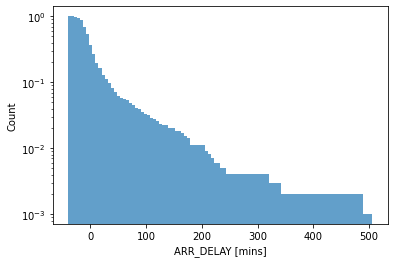

In [16]:
# example: plot BOI-DEN delay distribution
df_sub = df[(df['ORIGIN']=='BOI') & (df['DEST'] == 'DEN')]

plt.hist(df_sub['ARR_DELAY'], bins=100, density=True, histtype="stepfilled", alpha=.7, cumulative=-1)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('ARR_DELAY [mins]')
plt.yscale('log')

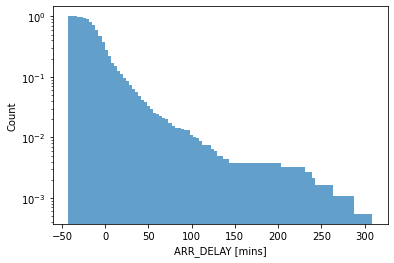

In [17]:
# example 2: plot BOI-SEA delay distribution
df_sub_2 = df[(df['ORIGIN']=='BOI') & (df['DEST'] == 'SEA')]

plt.hist(df_sub_2['ARR_DELAY'], bins=100, density=True, histtype="stepfilled", alpha=.7, cumulative=-1)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('ARR_DELAY [mins]')
plt.yscale('log')